# GDSC Drug Sensitivity Data Importation
**Local Version**: 2
**Source Version**: 6.0

This notebook will import prepared drug sensitivity data through the [GDSC](http://www.cancerrxgene.org/downloads) portal which hosts these files on the [Sanger FTP Server](ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/) (release-6.0 in this case)

Note that the GDSC exposes 3 drug datasets, labeled as the following:

1. Raw - "compound sensitivity data for Cell lines"
2. Preprocessed - "log(IC50) and AUC values"
3. Preprocessed - "ANOVA results"

In this case option 2 will be used, but the others are worth future consideration.

In [113]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%run -m ipy_plotly
%matplotlib inline
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import io_utils as io
from py_utils import assertion_utils
pd.set_option('display.max_info_rows', 50000000)

## Load Raw Sensitivity Data

In [114]:
url = 'ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx'
filepath = db.raw_file(src.GDSC_v2, 'drug-sensitivity.xlsx')
filepath = io.download(url, filepath, check_exists=True)
filepath

2016-11-30 15:12:37,656:DEBUG:mgds.data_aggregation.io_utils: Returning previously downloaded path for "/Users/eczech/data/research/mgds/raw/gdsc_v2_drug-sensitivity.xlsx"


'/Users/eczech/data/research/mgds/raw/gdsc_v2_drug-sensitivity.xlsx'

In [115]:
c_str = ['DATASET_VERSION', 'IC50_RESULTS_ID', 'COSMIC_ID', 'DRUG_ID']
d = pd.read_excel(filepath, sheetname='Export Worksheet', converters={c:str for c in c_str})
d = d.rename(columns={'COSMIC_ID': 'CELL_LINE_ID:COSMIC', 'DRUG_ID': 'DRUG_ID:COSMIC'})
d['DRUG_ID:COSMIC'] = d['DRUG_ID:COSMIC'].astype(np.int64)

# Ensure that the data all has the same associated version ("17"), and then lose this field
assert np.all(d['DATASET_VERSION'] == '17')
d = d.drop('DATASET_VERSION', axis=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224510 entries, 0 to 224509
Data columns (total 7 columns):
IC50_RESULTS_ID        224510 non-null object
CELL_LINE_ID:COSMIC    224510 non-null object
DRUG_ID:COSMIC         224510 non-null int64
MAX_CONC_MICROMOLAR    224510 non-null float64
LN_IC50                224510 non-null float64
AUC                    224510 non-null float64
RMSE                   224510 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 12.0+ MB


In [116]:
d.head()

,IC50_RESULTS_ID,CELL_LINE_ID:COSMIC,DRUG_ID:COSMIC,MAX_CONC_MICROMOLAR,LN_IC50,AUC,RMSE
0,335,924100,1026,1.0,0.717722,0.899410,0.105665
1,336,924100,1028,2.0,2.664100,0.957206,0.178243
2,337,924100,1029,2.0,3.336828,0.973893,0.079845
3,338,924100,1030,10.0,5.164909,0.977844,0.094228
4,339,924100,1031,0.2,-4.325309,0.508180,0.090478


## Load GDSC Drug Meta Data

In [117]:
url = 'ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/release-6.0/Screened_Compounds.xlsx'
filepath = db.raw_file(src.GDSC_v2, 'drug-meta.xlsx')
filepath = io.download(url, filepath, check_exists=True)
filepath

2016-11-30 15:12:59,037:DEBUG:mgds.data_aggregation.io_utils: Returning previously downloaded path for "/Users/eczech/data/research/mgds/raw/gdsc_v2_drug-meta.xlsx"


'/Users/eczech/data/research/mgds/raw/gdsc_v2_drug-meta.xlsx'

In [118]:
c_str = ['DRUG ID', 'DRUG NAME', 'TARGET', 'TARGET PATHWAY']
d_meta = pd.read_excel(filepath, sheetname='Export Worksheet', converters={c:str for c in c_str})
d_meta = d_meta.rename(columns={
    'DRUG ID': 'DRUG_ID:COSMIC', 
    'DRUG NAME': 'DRUG_NAME', 
    'TARGET PATHWAY': 'TARGET_PATHWAY'
})
d_meta['DRUG_ID:COSMIC'] = d_meta['DRUG_ID:COSMIC'].astype(np.int64)
d_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 5 columns):
DRUG_ID:COSMIC    265 non-null int64
DRUG_NAME         265 non-null object
SYNONYMS          149 non-null object
TARGET            264 non-null object
TARGET_PATHWAY    265 non-null object
dtypes: int64(1), object(4)
memory usage: 10.4+ KB


In [119]:
d_meta.head()

,DRUG_ID:COSMIC,DRUG_NAME,SYNONYMS,TARGET,TARGET_PATHWAY
0,1,Erlotinib,NaN,EGFR,EGFR signaling
1,3,Rapamycin,"AY-22989,Sirolimus,WY-090217",mTOR,TOR signaling
2,5,Sunitinib,Sutent,"PDGFRA, PDGFRB, KDR, KIT, FLT3",RTK signaling
3,6,PHA-665752,NaN,MET,RTK signaling
4,9,MG-132,zLLL,Proteasome,other


## Load Cell Line Meta Data

In [120]:
d_cl = db.load(src.GDSC_v2, db.IMPORT, 'cellline-meta')[['CELL_LINE_ID', 'CELL_LINE_ID:COSMIC']]
d_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029 entries, 0 to 1033
Data columns (total 2 columns):
CELL_LINE_ID           1029 non-null object
CELL_LINE_ID:COSMIC    1029 non-null object
dtypes: object(2)
memory usage: 24.1+ KB


## Merge Drug Data

In [121]:
# Merge sensitivity data to drug and cell line metadata
d_rx = pd.merge(d, d_meta, on=['DRUG_ID:COSMIC'], how='left')
d_rx = pd.merge(d_rx, d_cl, on=['CELL_LINE_ID:COSMIC'], how='left')

# Make sure that all drugs were joined (this will be null otherwise)
assert np.all(d_rx['DRUG_NAME'].notnull())

# Ensure some other key fields are never null
assert np.all(d_rx[['DRUG_ID:COSMIC', 'CELL_LINE_ID:COSMIC', 'AUC', 'RMSE', 'LN_IC50']].notnull())

# Make sure cell line + drug combinations are unique for both types of cell line identifiers
assert not np.any(d_rx[['CELL_LINE_ID:COSMIC', 'DRUG_ID:COSMIC']].duplicated())
assert not np.any(d_rx[['CELL_LINE_ID', 'DRUG_ID:COSMIC']].dropna().duplicated())

# Make sure cell line ids have no conflicts
assert d_rx.groupby('CELL_LINE_ID')['CELL_LINE_ID:COSMIC'].nunique().max() == 1
assert d_rx.groupby('CELL_LINE_ID:COSMIC')['CELL_LINE_ID'].nunique().max() == 1

d_rx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224510 entries, 0 to 224509
Data columns (total 12 columns):
IC50_RESULTS_ID        224510 non-null object
CELL_LINE_ID:COSMIC    224510 non-null object
DRUG_ID:COSMIC         224510 non-null int64
MAX_CONC_MICROMOLAR    224510 non-null float64
LN_IC50                224510 non-null float64
AUC                    224510 non-null float64
RMSE                   224510 non-null float64
DRUG_NAME              224510 non-null object
SYNONYMS               121336 non-null object
TARGET                 223541 non-null object
TARGET_PATHWAY         224510 non-null object
CELL_LINE_ID           216576 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 22.3+ MB


In [122]:
d_rx.head()

,IC50_RESULTS_ID,CELL_LINE_ID:COSMIC,DRUG_ID:COSMIC,MAX_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,DRUG_NAME,SYNONYMS,TARGET,TARGET_PATHWAY,CELL_LINE_ID
0,335,924100,1026,1.0,0.717722,0.899410,0.105665,17-AAG,tanespimycin,HSP90,other,22RV1
1,336,924100,1028,2.0,2.664100,0.957206,0.178243,VX-702,NaN,p38,JNK and p38 signaling,22RV1
2,337,924100,1029,2.0,3.336828,0.973893,0.079845,AMG-706,AMG-706,"VEGFR, RET, c-KIT, PDGFR",RTK signaling,22RV1
3,338,924100,1030,10.0,5.164909,0.977844,0.094228,KU-55933,NaN,ATM,Genome integrity,22RV1
4,339,924100,1031,0.2,-4.325309,0.508180,0.090478,Elesclomol,NaN,HSP70,other,22RV1


## Resolve drugs with non-unique names (by COSMIC drug id)

In [128]:
# Find drugs with multiple cosmic ids per drug name
dupe_drugs = d_rx[d_rx[['DRUG_NAME', 'CELL_LINE_ID:COSMIC']].duplicated()]['DRUG_NAME'].unique()
dt = d_rx[d_rx['DRUG_NAME'].isin(dupe_drugs)]

# For each dupe drug, pivot dupe values into columns (there are 2) with cell line index and IC50 as value
def get_bivar(g):
    g = g.set_index(['CELL_LINE_ID:COSMIC', 'DRUG_ID:COSMIC'])['LN_IC50'].unstack()
    g.columns = ['C1', 'C2']
    return g.reset_index()
dt = dt.groupby(['DRUG_NAME']).apply(get_bivar).reset_index().drop('level_1', axis=1)

# Plot correlation between duplciated values
traces = [go.Scatter(x=g['C1'], y=g['C2'], name=k, mode='markers', opacity=.8) for k, g in dt.groupby('DRUG_NAME')]
fig = go.Figure(data=traces, layout=go.Layout(title='2x Duplicates by Drug Name (2 COSMIC drug ids)'))
plty.offline.iplt(fig)

In [124]:
dupe_drugs

array(['PLX4720', 'Afatinib', 'selumetinib', 'GDC0941', 'AZD6482',
       'BMS-708163', 'JQ1', 'UNC0638', 'CHIR-99021', 'Olaparib',
       'Bicalutamide', 'RDEA119', 'BMS-536924', 'GSK269962A'], dtype=object)

In [138]:
drug_name = 'PLX4720'
dt = d_rx[d_rx['DRUG_NAME'] == drug_name]
dt = dt.set_index(['CELL_LINE_ID:COSMIC', 'DRUG_ID:COSMIC'])['LN_IC50'].unstack()
dt.index = ['cl_{}'.format(v) for v in dt.index]
traces = [go.Scatter(x=dt.index, y=dt[c], name=c) for c in dt]
cf.iplot(traces)

In [105]:
# For now, arbitrarily choose between duplicates:
def get_id_to_ignore(g):
    assert len(g['DRUG_ID:COSMIC']) > 0
    return g['DRUG_ID:COSMIC'].min()
d_ignore = d_rx[d_rx['DRUG_NAME'].isin(dupe_drugs)].groupby('DRUG_NAME').apply(get_id_to_ignore)
d_rxu = d_rx[~d_rx['DRUG_ID:COSMIC'].isin(d_ignore.values)]
d_rxu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212665 entries, 0 to 224509
Data columns (total 12 columns):
IC50_RESULTS_ID        212665 non-null object
CELL_LINE_ID:COSMIC    212665 non-null object
DRUG_ID:COSMIC         212665 non-null int64
MAX_CONC_MICROMOLAR    212665 non-null float64
LN_IC50                212665 non-null float64
AUC                    212665 non-null float64
RMSE                   212665 non-null float64
DRUG_NAME              212665 non-null object
SYNONYMS               113092 non-null object
TARGET                 211696 non-null object
TARGET_PATHWAY         212665 non-null object
CELL_LINE_ID           205148 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 21.1+ MB


## Bivariate Distributions for AUC v IC50

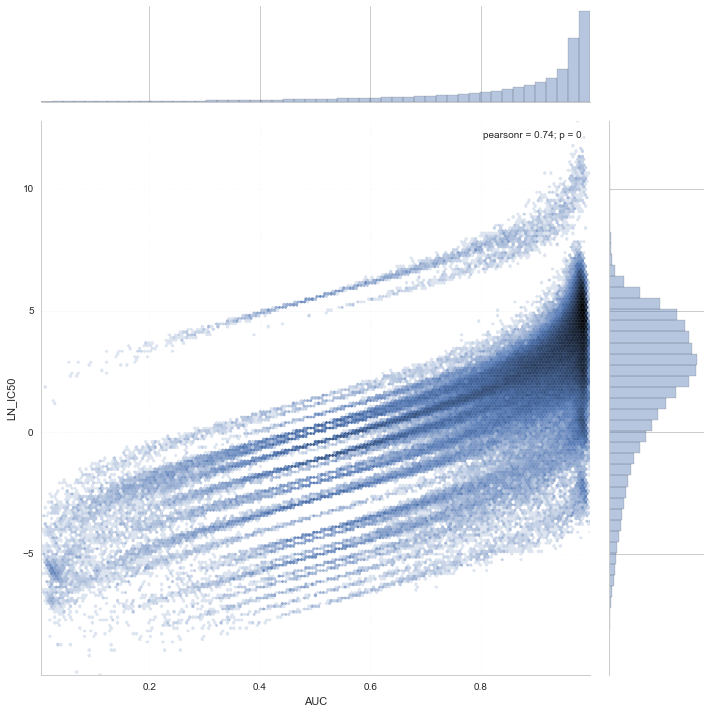

In [107]:
sns.jointplot('AUC', 'LN_IC50', data=d_rxu, kind='hex', bins='log', size=10)

In [108]:
ids = d_rxu['DRUG_ID:COSMIC'].drop_duplicates().sample(n=25).values
d_plt = d_rxu[d_rxu['DRUG_ID:COSMIC'].isin(ids)]
traces = [
    go.Scatter(x=g['AUC'], y=g['LN_IC50'], name=k, mode='markers', showlegend=True, text=g['CELL_LINE_ID']) 
    for k, g in d_plt.groupby('DRUG_NAME')
]
fig = go.Figure(data=traces, layout=go.Layout(hovermode='closest'))
plty.offline.iplt(fig)

## Export

In [109]:
assertion_utils.assert_object_types(d_rxu)
db.save(d_rxu, src.GDSC_v2, db.IMPORT, 'drug-sensitivity')

'/Users/eczech/data/research/mgds/import/gdsc_v2_drug-sensitivity.pkl'